In [437]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# for number crunching
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns

# Extre libraries
from datetime import datetime

/kaggle/input/online-retail-ii-uci/online_retail_II.csv


In [438]:
os.listdir('/kaggle/input/online-retail-ii-uci')

['online_retail_II.csv']

In [439]:
data = pd.read_csv('/kaggle/input/online-retail-ii-uci/online_retail_II.csv')

data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# Creating necessary columns

In [440]:
# Making sure Date is in datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Total ammount column
data['TotalAmount'] = data['Price'] * data['Quantity']

data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [441]:
# Deleting all rows with null values
data = data.dropna(subset = ['Customer ID'])

# Eliminating rows with negative quantities

# Note: don't eliminate this data, TO BE DETERMINED

data = data[data['Quantity'] >= 0]

data = data[data['Price'] >= 0]

In [442]:
# Validating null values again
data.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
TotalAmount    0
dtype: int64

In [443]:
# Validating negative values again
(data[['Price', 'Quantity', 'TotalAmount']] < 0).sum()

Price          0
Quantity       0
TotalAmount    0
dtype: int64

# Data Cleaning

In [444]:
# We'll only work with transactions from the UK

# Keeping only transactions made in the UK
data = data[data['Country'] == 'United Kingdom']

In [445]:
print(data['Country'].describe())

count             725296
unique                 1
top       United Kingdom
freq              725296
Name: Country, dtype: object


# Data division between present and future

In [446]:
futureMax = data['InvoiceDate'].max()

print(futureMax)

2011-12-09 12:49:00


In [447]:
# Data delimitation (three months before)
presentvalue = pd.Timestamp('2011-09-01')

print(presentvalue)

2011-09-01 00:00:00


In [448]:
# Dividing data between present and future
futureData = data[(data['InvoiceDate'] > presentvalue) & (data['InvoiceDate'] <= presentvalue + pd.DateOffset(months=3))]

data = data[data['InvoiceDate'] <= presentvalue]

# Creating Customer Dataset

In [449]:
# Calculating the "present day" for metrics like Recency
presentDay = presentvalue

# Calculate date metrics
firstPurchase = data.groupby('Customer ID')['InvoiceDate'].min()
lastPurchase = data.groupby('Customer ID')['InvoiceDate'].max()

# Calculate customer lifespan metrics
# We don't want 0 in active days. First day counts as 1.
activeDays = (lastPurchase - firstPurchase).dt.days + 1

# Recency calculation (Days since last purchase)
recency = (presentDay - lastPurchase).dt.days

activeYears = activeDays / 365.25
activeMonths = activeDays / 30.44

# A stabilization for active months so FrequencyPerMonth doesn't give
# new customer extreme values
activeMonthsSafe = np.maximum(activeMonths, 1)

# Last 30 days
last_30d = data[data['InvoiceDate'] > presentDay - pd.DateOffset(days=30)]
last_30d_spending = last_30d.groupby('Customer ID')['TotalAmount'].sum()
last_30d_frequency = last_30d.groupby('Customer ID')['Invoice'].nunique()

# Last 60 days
last_60d = data[data['InvoiceDate'] > presentDay - pd.DateOffset(days=60)]
last_60d_spending = last_60d.groupby('Customer ID')['TotalAmount'].sum()
last_60d_frequency = last_60d.groupby('Customer ID')['Invoice'].nunique()

# Last 90 days
last_90d = data[data['InvoiceDate'] > presentDay - pd.DateOffset(days=90)]
last_90d_spending = last_90d.groupby('Customer ID')['TotalAmount'].sum()
last_90d_frequency = last_90d.groupby('Customer ID')['Invoice'].nunique()

# Frequency calculation
purchaseFrequency = data.groupby('Customer ID')['Invoice'].nunique()

# Monetary for calculations
monetary = data.groupby('Customer ID')['TotalAmount'].sum()

# Quantity calculation (calculating the total quantity per invoice)
invoiceQuantity = data.groupby(['Customer ID','Invoice'])['Quantity'].sum().reset_index()
avgQuantityPerInvoice = invoiceQuantity.groupby('Customer ID')['Quantity'].mean()

customerData = data.groupby('Customer ID').agg(

    # Monetary (Total Amount of purchases)
    Monetary = ('TotalAmount', 'sum'),
    
    # Average item Price
    #AvgPrice = ('Price', 'mean'), 
    
    # How many unique products bought
    ProductDiversity = ('StockCode', 'nunique')
)

# Recency calculation (Days since last purchase)
customerData['Recency'] = recency

# Frequency calculation
customerData['Frequency'] = purchaseFrequency

# Average order value calculation
customerData['AvgInvoiceValue'] = monetary / purchaseFrequency

# Average Quantity table merge
customerData['AvgQuantityPerInvoice'] = avgQuantityPerInvoice

# Active days
customerData['ActiveDays'] = activeDays

# Average item price
AvgPrice = data.groupby('Customer ID').apply(lambda x: x['TotalAmount'].sum() / x['Quantity'].sum())

# Spending in different time windows
customerData['Spending_Last30d'] = last_30d_spending
customerData['Spending_Last60d'] = last_60d_spending
customerData['Spending_Last90d'] = last_90d_spending

# Frequency in different time windows
customerData['Frequency_Last30d'] = last_30d_frequency
customerData['Frequency_Last60d'] = last_60d_frequency
customerData['Frequency_Last90d'] = last_90d_frequency

# Fill NaN values with 0 for customers with no activity in recent windows
temporal_cols = ['Spending_Last30d', 'Spending_Last60d', 'Spending_Last90d',
                 'Frequency_Last30d', 'Frequency_Last60d', 'Frequency_Last90d']

customerData[temporal_cols] = customerData[temporal_cols].fillna(0)

# Frequency per month
customerData['FrequencyPerMonth'] = purchaseFrequency / activeMonthsSafe

# Calculation of future CLV (spending in the next Quarter), which will be the target
futureCLV = futureData.groupby('Customer ID')['TotalAmount'].sum().rename('FutureCLV')
finalDataset = customerData.merge(futureCLV, how = 'left', left_index = True, right_index = True)
# Filling customers with no spending with a 0 value
finalDataset['FutureCLV'] = finalDataset['FutureCLV'].fillna(0)

# Eliminating customers with only 1 purchase as they only worsen the MAE
finalDataset = finalDataset[finalDataset['Frequency'] >= 2]

finalDataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3348 entries, 12346.0 to 18287.0
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Monetary               3348 non-null   float64
 1   ProductDiversity       3348 non-null   int64  
 2   Recency                3348 non-null   int64  
 3   Frequency              3348 non-null   int64  
 4   AvgInvoiceValue        3348 non-null   float64
 5   AvgQuantityPerInvoice  3348 non-null   float64
 6   ActiveDays             3348 non-null   int64  
 7   Spending_Last30d       3348 non-null   float64
 8   Spending_Last60d       3348 non-null   float64
 9   Spending_Last90d       3348 non-null   float64
 10  Frequency_Last30d      3348 non-null   float64
 11  Frequency_Last60d      3348 non-null   float64
 12  Frequency_Last90d      3348 non-null   float64
 13  FrequencyPerMonth      3348 non-null   float64
 14  FutureCLV              3348 non-null   float64
dtype

/tmp/ipykernel_47/1337570770.py:75: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  AvgPrice = data.groupby('Customer ID').apply(lambda x: x['TotalAmount'].sum() / x['Quantity'].sum())


In [450]:
# Saving a clean copy of the final dataset before cleaning it
rawCustomerDataset = finalDataset.copy()

In [451]:
finalDataset = finalDataset[finalDataset['Monetary'] < finalDataset['Monetary'].quantile(0.98)]

# Binarizing FutureCLV

In [452]:
threshold = finalDataset['FutureCLV'].quantile(0.90)

finalDataset['BoolFutureCLV'] = (finalDataset['FutureCLV'] >= threshold).astype(int)

In [453]:
finalDataset = finalDataset.drop(columns =['FutureCLV'])

In [454]:
finalDataset['BoolFutureCLV'].value_counts()
finalDataset['BoolFutureCLV'].value_counts(normalize=True)

BoolFutureCLV
0    0.899726
1    0.100274
Name: proportion, dtype: float64

# Client segmentation (Excluding clients with outlying purchase patters)

In [455]:
#Dropping the outliers from data and saving them on other dataset!
# finalDatasetOutliersMonetary= finalDataset[finalDataset['Monetary'] > finalDataset['Monetary'].quantile(0.98)]

#finalDataset = finalDataset[finalDataset['Monetary'] < finalDataset['Monetary'].quantile(0.98)]
# finalDataset = finalDataset[finalDataset['AvgInvoiceValue'] < finalDataset['AvgInvoiceValue'].quantile(0.98)]
# finalDataset = finalDataset[finalDataset['AvgQuantityPerInvoice'] < finalDataset['AvgQuantityPerInvoice'].quantile(0.98)]
# finalDataset = finalDataset[finalDataset['Frequency'] < finalDataset['Frequency'].quantile(0.98)]
# finalDataset = finalDataset[finalDataset['FrequencyPerMonth'] < finalDataset['FrequencyPerMonth'].quantile(0.99)]
# finalDataset = finalDataset[finalDataset['FutureCLV'] < finalDataset['FutureCLV'].quantile(0.99)]
# finalDataset = finalDataset[finalDataset['FrequencyPerMonth'] < finalDataset['FrequencyPerMonth'].quantile(0.99)]
# finalDataset = finalDataset[finalDataset['ProductDiversity'] < finalDataset['ProductDiversity'].quantile(0.99)]

# Probando eliminando los clientes que no compran en ese trimestre!
#finalDataset = finalDataset[finalDataset['FutureCLV'] > 0]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Monetary', ylabel='Percent'>

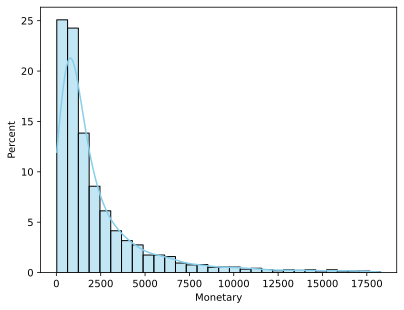

In [456]:
sns.histplot(finalDataset['Monetary'],bins=30, kde=True, color="skyblue", stat="percent")

In [457]:
print(finalDataset['Monetary'].describe())

count     3281.000000
mean      2297.498232
std       2780.334966
min         24.050000
25%        631.680000
50%       1266.820000
75%       2739.800000
max      18272.990000
Name: Monetary, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='AvgInvoiceValue', ylabel='Percent'>

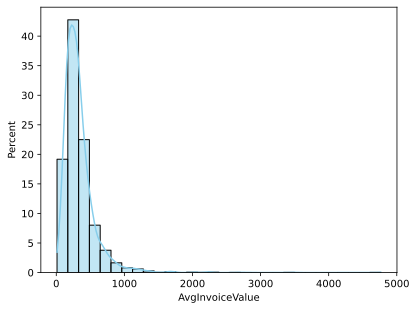

In [458]:
sns.histplot(finalDataset['AvgInvoiceValue'],bins=30, kde=True, color="skyblue", stat="percent")

In [459]:
print(finalDataset['AvgInvoiceValue'].describe())

count    3281.000000
mean      333.366094
std       242.215068
min        11.161333
25%       192.312857
50%       283.590000
75%       401.186667
max      4765.040000
Name: AvgInvoiceValue, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='AvgQuantityPerInvoice', ylabel='Percent'>

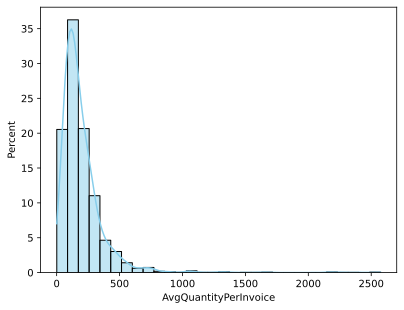

In [460]:
sns.histplot(finalDataset['AvgQuantityPerInvoice'],bins=30, kde=True, color="skyblue", stat="percent")

In [461]:
print(finalDataset['AvgQuantityPerInvoice'].describe())

count    3281.000000
mean      197.829889
std       183.530656
min         1.000000
25%        96.000000
50%       153.200000
75%       244.300000
max      2574.000000
Name: AvgQuantityPerInvoice, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='FrequencyPerMonth', ylabel='Percent'>

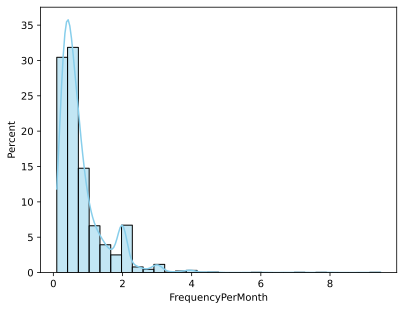

In [462]:
sns.histplot(finalDataset['FrequencyPerMonth'],bins=30, kde=True, color="skyblue", stat="percent")

In [463]:
print(finalDataset['FrequencyPerMonth'].describe())

count    3281.000000
mean        0.809210
std         0.691079
min         0.099477
25%         0.375802
50%         0.579810
75%         0.974080
max         9.461081
Name: FrequencyPerMonth, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Frequency', ylabel='Percent'>

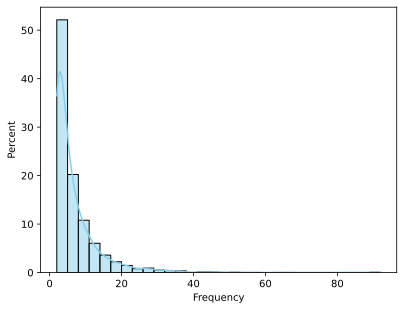

In [464]:
sns.histplot(finalDataset['Frequency'],bins=30, kde=True, color="skyblue", stat="percent")

In [465]:
print(finalDataset['Frequency'].describe())

count    3281.000000
mean        6.662603
std         6.847144
min         2.000000
25%         3.000000
50%         4.000000
75%         8.000000
max        92.000000
Name: Frequency, dtype: float64


# Data Normalization

In [466]:
modelData = finalDataset.copy()

In [467]:
# log transform for heavytail data
logCols = ['Monetary', 'AvgInvoiceValue', 'AvgQuantityPerInvoice', 'Frequency', 'Spending_Last30d', 'Spending_Last60d', 'Spending_Last90d', 'Frequency_Last30d', 'Frequency_Last60d', 'Frequency_Last90d']

for col in logCols:
    modelData[col] = np.log1p(modelData[col])

# Definition of train/test/val datasets and Robust scaling

In [468]:
# Separating inputs and outputs
X = finalDataset.drop(columns = ['BoolFutureCLV'])
y = finalDataset['BoolFutureCLV']

In [469]:
# Train and temp split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)

# Val and test splot
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

In [470]:
# Robust Scaling
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

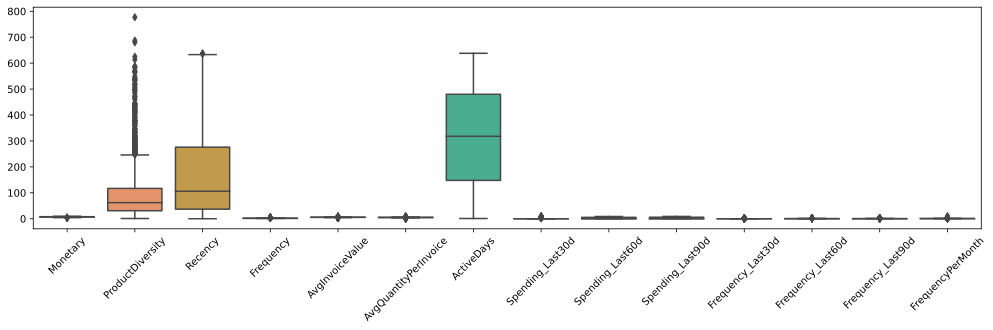

In [471]:
# check the new distribution
Showdata=modelData.drop(columns=['BoolFutureCLV'])
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(Showdata)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [472]:
# Separating features from target
X = modelData.drop(columns=['BoolFutureCLV'])
y = modelData['BoolFutureCLV']

# Split en train, test y val (70%, 15%, 15%)

# Train and temp split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)

# Val and test splot
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

# Pandas dataframe to tensor conversion
X_train_t = torch.tensor(X_train.values).float()
X_val_t   = torch.tensor(X_val.values).float()
X_test_t  = torch.tensor(X_test.values).float()

y_train_t = torch.tensor(y_train.values).float().unsqueeze(1)
y_val_t   = torch.tensor(y_val.values).float().unsqueeze(1)
y_test_t  = torch.tensor(y_test.values).float().unsqueeze(1)

In [473]:
# Dataloaders

batchSize = 32

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=batchSize, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batchSize, shuffle=True)

In [474]:
print(X_train_t.shape)
print(X_val_t.shape)
print(X_test_t.shape)

torch.Size([2296, 14])
torch.Size([492, 14])
torch.Size([493, 14])


# Creating and trainning the FFNN

In [475]:
# Creating a class for the model without batchnorm

class FFNN(nn.Module):
  def __init__(self):
    super().__init__()

    # input layer
    self.input = nn.Linear(14,32)

    # hidden layer 1
    self.fc1    = nn.Linear(32,16)

    # hidden layer 2
    self.fc2    = nn.Linear(16,8)

    # output layer
    self.output = nn.Linear(8,1)

    # Dropout
    self.dropout = nn.Dropout(p=0.2)

  # forward pass
  def forward(self,x):

    # input
    x = self.input(x)    # weighted combination
    x = F.relu(x)      # activation function 
    x = self.dropout(x)  # dropout
      
    # hidden layer 1
    x = self.fc1(x)    # weighted combination
    x = F.relu(x)      # activation function
    x = self.dropout(x)  # dropout
    
    # hidden layer 2
    x = self.fc2(x)    # weighted combination
    x = F.relu(x)      # activation function 

    # output layer
    return self.output(x)

In [476]:
pos_weight = torch.tensor((y_train == 0).sum() / (y_train == 1).sum())

# grab an instance of the model class
model = FFNN()

# loss function
lossfun = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# optimizer with L2 Regularization 
optimizer = torch.optim.AdamW(model.parameters(),lr= 0.001,weight_decay=0.0001)

# Scheduler for learning rate decay
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,     # reduce LR by half
    patience=10,     # wait 15 epochs with no improvement
    min_lr = 0.000001,
    verbose = True # helps debugging
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [477]:
# train the model

# Evaluation function
def evaluateModel(model, loader):
    model.eval()

    probs = []
    trues = []

    with torch.no_grad():
        for X, y in loader:
            logits = model(X)
            prob = torch.sigmoid(logits)

            probs.append(prob.cpu().numpy())
            trues.append(y.cpu().numpy())

    probs = np.vstack(probs).ravel()
    trues = np.vstack(trues).ravel()

    preds = (probs >= 0.5).astype(int)

    return {
        "accuracy": accuracy_score(trues, preds),
        "precision": precision_score(trues, preds, zero_division=0),
        "recall": recall_score(trues, preds, zero_division=0),
        "f1": f1_score(trues, preds, zero_division=0),
        "roc_auc": roc_auc_score(trues, probs)
    }

# Epochs
numepochs = 100

def trainTheModel():

    # initialize losses as empties
    trainLosses = []
    valLosses = []
    
    # loop over epochs
    for epoch in range(numepochs):
    
        # Toggle train mode
        model.train()
        batchLoss = []
          
        # initialize batchAcc and batchLoss
        batchAcc  = []
        batchLoss = []
        
        for X,y in train_loader:
          # Clear old gradients  
          optimizer.zero_grad()  
        
          # forward pass and loss
          yhat = model(X)
          loss = lossfun(yhat,y)
        
          # backprop
          loss.backward()
          optimizer.step()
        
          # Append batch Loss
          batchLoss.append( loss.item())
          
        # Average trainning loss for this epoch
        trainLoss = np.mean(batchLoss)
        trainLosses.append(trainLoss)

        # Turning on validation mode
        model.eval()
        with torch.no_grad():
            valLossBatch = []

            for Xv, yv in val_loader:
                yhatv = model(Xv)
                valLossBatch.append(lossfun(yhatv, yv).item())

        valLoss = np.mean(valLossBatch)
        valLosses.append(valLoss)

        # Metrics
        metrics = evaluateModel(model, val_loader)
            
        # Scheduler
        scheduler.step(valLoss)

        # Progress print
        print(
            f"Epoch {epoch:03d} | "
            f"TrainLoss: {trainLoss:.4f} | "
            f"ValLoss: {valLoss:.4f} | "
            f"Recall: {metrics['recall']:.3f} | "
            f"Precision: {metrics['precision']:.3f} | "
            f"ROC-AUC: {metrics['roc_auc']:.3f}"
        )
    
    # function output
    return trainLosses, valLosses

In [478]:
# Train the model
trainLosses, valLosses = trainTheModel()

Epoch 000 | TrainLoss: 1.4333 | ValLoss: 1.0129 | Recall: 0.750 | Precision: 0.265 | ROC-AUC: 0.820
Epoch 001 | TrainLoss: 1.1956 | ValLoss: 1.0348 | Recall: 0.712 | Precision: 0.306 | ROC-AUC: 0.817
Epoch 002 | TrainLoss: 1.1515 | ValLoss: 1.0173 | Recall: 0.750 | Precision: 0.310 | ROC-AUC: 0.820
Epoch 003 | TrainLoss: 1.1242 | ValLoss: 1.0097 | Recall: 0.673 | Precision: 0.324 | ROC-AUC: 0.826
Epoch 004 | TrainLoss: 1.1585 | ValLoss: 1.0396 | Recall: 0.692 | Precision: 0.261 | ROC-AUC: 0.819
Epoch 005 | TrainLoss: 1.1009 | ValLoss: 1.0083 | Recall: 0.712 | Precision: 0.248 | ROC-AUC: 0.825
Epoch 006 | TrainLoss: 1.1062 | ValLoss: 1.0201 | Recall: 0.692 | Precision: 0.286 | ROC-AUC: 0.824
Epoch 007 | TrainLoss: 1.0986 | ValLoss: 1.0404 | Recall: 0.712 | Precision: 0.239 | ROC-AUC: 0.818
Epoch 008 | TrainLoss: 1.0929 | ValLoss: 1.0015 | Recall: 0.712 | Precision: 0.262 | ROC-AUC: 0.826
Epoch 009 | TrainLoss: 1.0643 | ValLoss: 0.9645 | Recall: 0.769 | Precision: 0.255 | ROC-AUC: 0.824


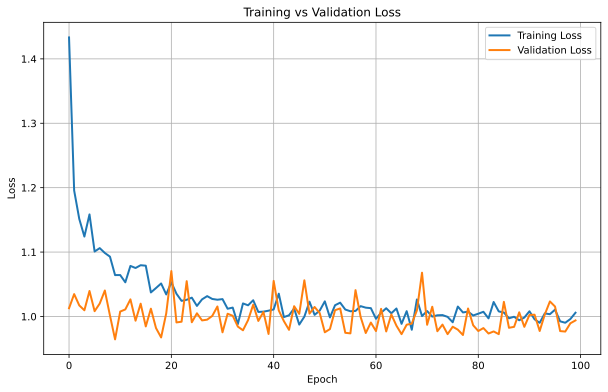

In [479]:
plt.figure(figsize=(10,6))

plt.plot(trainLosses, label='Training Loss', linewidth=2)
plt.plot(valLosses, label='Validation Loss', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()